# Two Gaussian distributions

In [79]:
# brew install python@3.12 # torch cannot handle higher versions of python
# python3.12 -m venv venv_py312
# source venv_py312/bin/activate
# pip3 install torch torchvision
# pip3 install matplotlib
# pip3 install scipy

/var/folders/b4/my86xy1s7kd2m9bg9txms_yc0000gn/T/ipykernel_44062/3708981947.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples1 = np.random.multivariate_normal(mean1, cov1, n1)
/var/folders/b4/my86xy1s7kd2m9bg9txms_yc0000gn/T/ipykernel_44062/3708981947.py:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples2 = np.random.multivariate_normal(mean2, cov2, n2)


(np.float64(-5.1702030662029985),
 np.float64(6.273982288474692),
 np.float64(-5.742616687833998),
 np.float64(5.701568666843693))

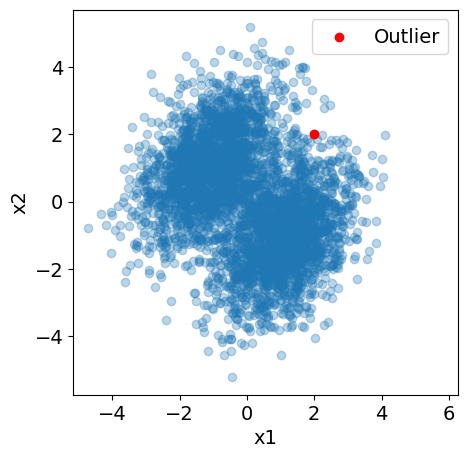

In [80]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set figure font size
plt.rcParams.update({'font.size': 14})

# Set random seed for reproducibility
np.random.seed(42)

# Generate samples from first Gaussian
n1 = 2000
mean1 = [1.1, -1.1]
cov1 = np.array([[1, 1], [0, 1]])
cov1 = 1.1*cov1
samples1 = np.random.multivariate_normal(mean1, cov1, n1)

# Generate samples from second Gaussian
n2 = 2000
mean2 = [-1.1,  1.1] 
cov2 = np.array([[1, 1], [0, 1]]) 
cov2 = 1.1*cov2
samples2 = np.random.multivariate_normal(mean2, cov2, n2)

# Combine samples
X = np.vstack([samples1, samples2])

outlier_index = 15
X[outlier_index, 0] = 2 # Set an extreme value 
X[outlier_index, 1] = 2 # Set an extreme value 

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], alpha=0.3, label=None)
plt.scatter(X[outlier_index, 0], X[outlier_index, 1], color='red', label='Outlier')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.axis('square')

# Principal Components and why they're useful

We want to find the direction along which the data vary most and least. 
Finding these directions, called principal components, can be very useful when your data is high-dimensional but only a few of the directions account for most of the variation. For example, if the data lived in 1000-dimensional space, but almost all of the variation occurred along a particular direction, you could approximate each data-point quite well using its projection onto that direction. That would aid visualization and allow you to compress the data because each data point would now be represented by a single coordinate instead of 1000 of them (see later).

# Singular Value Decomposition (SVD)

SVD can be used to find the principal components of a data set. 

Let $X$ be the $m\times n$ matrix whose rows are the data-points. There are $m$ data points and each data point has $n$ dimensions. Decompose $X$ using the Singular Value Decomposition (SVD):

$$X = U \Sigma V^T$$

Here, $\Sigma$ is a diagonal matrix whose diagonal entries are positive and in decreasing order (the largest lies in the upper left corner of $\Sigma$). The other matrices, $U$ and $V$, are orthogonal matrices, i.e. their columns are orthonormal vectors.

The columns of $V$ are the significant directions we were looking for. $\Sigma$'s entries are the amount of variance of the data along those directions. Finally, $U$ (or more precisely $U\Sigma$) stores how you write each row of $X$ in terms of the columns of $V$. 



### Mean normalization

In [81]:
mean_X = np.apply_along_axis(np.mean, 0, X)
X_n = X - mean_X

There is a reason for this "mean normalization": If the mean is not zero, the "most significant direction" will be skewed towards the direction of the mean, and we don't want that.

### Compute the principal components of the data set


In [82]:
import scipy.linalg

U, s, Vt = scipy.linalg.svd(X_n)

In [83]:
# diagonal elements of matrix Sigma
# notice that the singular values are ordered, with largest first
s 

array([111.55330584,  82.38893916])

In [84]:
# Construct the matrix Sigma from the singular values contained in the variable `s`

m = len(U)
n = len(Vt)
Sigma = np.zeros((m, n))
for i in range(min(m, n)):
    Sigma[i, i] = s[i]
    
print('shape of U =', U.shape)
print('shape of Vt (or V) =', Vt.shape)
print('shape of Sigma =', Sigma.shape)

shape of U = (4000, 4000)
shape of Vt (or V) = (2, 2)
shape of Sigma = (4000, 2)


In [85]:
Vt # transpose of matrix V

array([[ 0.58366441, -0.81199499],
       [ 0.81199499,  0.58366441]])

(np.float64(-5.176090415959226),
 np.float64(6.268094938718465),
 np.float64(-5.740553724490505),
 np.float64(5.703631630187186))

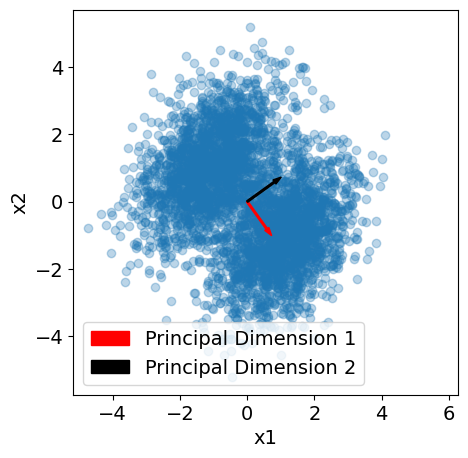

In [86]:
# extract rows of Vt, which are the columns of V
v1 = Vt[0,:]
v2 = Vt[1,:]

plt.figure(figsize=(5,5))
plt.scatter(X_n[:,0], X_n[:,1], alpha=0.3)
plt.arrow(0, 0, v1[0], v1[1], width=0.05, head_width=0.15, head_length=0.25, color="red", label='Principal Dimension 1')
plt.arrow(0, 0, v2[0], v2[1], width=0.05, head_width=0.15, head_length=0.25, color="black", label='Principal Dimension 2')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('square')

# Approximating the data set

Let's now approximate the data set `X_n`. We do this by retaining only the first $k$ of the singular values contained in `s` or, equivalently, by retaining only the first $k$ rows and columns of $\Sigma$. We similarly contract $U$ to one containing just the first $k$ columns and contract $V^T$ to one containing just the first $k$ rows. 

This approximation of the matrix `X_n`, which we'll call `X_n_hat`, is called a **low-rank approximation** because the approximate matrix has rank `k`, which is typically smaller than the rank of `X`. 

Also, it can be shown that the approximation, `X_n_hat`, is the matrix of rank `k` that is closest (under the Frobenius norm) to the original matrix `X_n`. This foreshadows our discussion of autoencoders (below).

In [87]:
# Construct approximations of `X_n` using its SVD and $k=1$
k = 1 
X_n_hat = np.dot(U[:,:k], Sigma[:k,:k]).dot(Vt[:k,:]) 

(np.float64(-5.176090415959226),
 np.float64(6.268094938718465),
 np.float64(-5.740553724490505),
 np.float64(5.703631630187186))

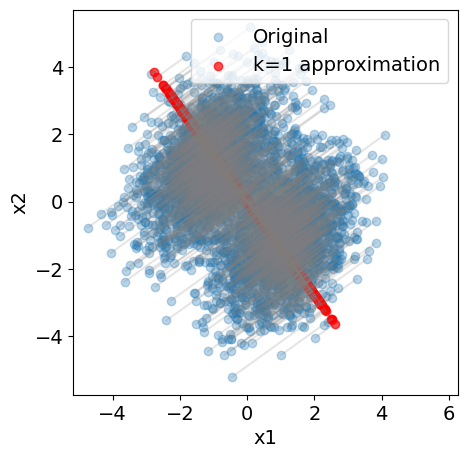

In [88]:
plt.figure(figsize=(5,5))
plt.scatter(X_n[:,0], X_n[:,1], alpha=0.3, label='Original')
plt.scatter(X_n_hat[:,0], X_n_hat[:,1], 
           color='red', alpha=0.7, label=f'k={k} approximation')

# Draw lines between original and approximated points to show the difference
for i in range(len(X_n)):
    plt.plot([X_n[i,0], X_n_hat[i,0]], 
             [X_n[i,1], X_n_hat[i,1]], 
             'gray', alpha=0.2)

plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('square')

Notice that we we can compress the data set using two numbers representing the (red) line (slope and intercept), and one number representing the position of the data points when projected onto the line. 

# Approximating the data yields a latent representation that reveals the clusters

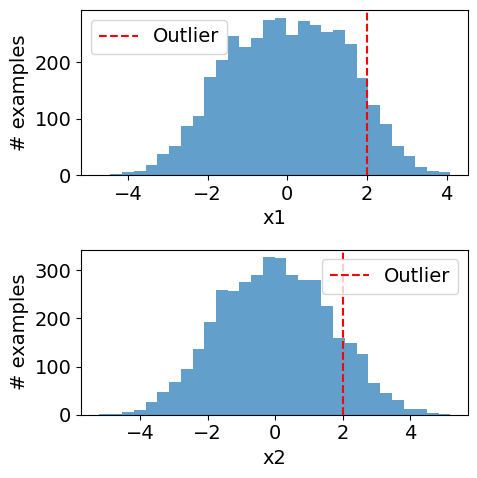

In [89]:
# Plot distribution of first and second coordinates
plt.figure(figsize=(5,5))

# First coordinate distribution
plt.subplot(2,1,1)
# plt.hist(X_n[:n1,0], bins=30, alpha=0.7, label='Gaussian 1')
# plt.hist(X_n[n1:,0], bins=30, alpha=0.7, label='Gaussian 2')
plt.hist(X_n[:,0], bins=30, alpha=0.7, label=None)

# Add vertical line for outlier value
plt.axvline(x=X_n[outlier_index, 0], color='r', linestyle='--', label='Outlier')

plt.xlabel('x1')
plt.ylabel('# examples')
plt.legend()

# Second coordinate distribution 
plt.subplot(2,1,2)
# plt.hist(X_n[:n1,1], bins=30, alpha=0.7, label='Gaussian 1')
# plt.hist(X_n[n1:,1], bins=30, alpha=0.7, label='Gaussian 2')
plt.hist(X_n[:,1], bins=30, alpha=0.7, label=None)

plt.axvline(x=X_n[outlier_index, 1], color='r', linestyle='--', label='Outlier')

plt.xlabel('x2')
plt.ylabel('# examples')
plt.legend()

plt.tight_layout()

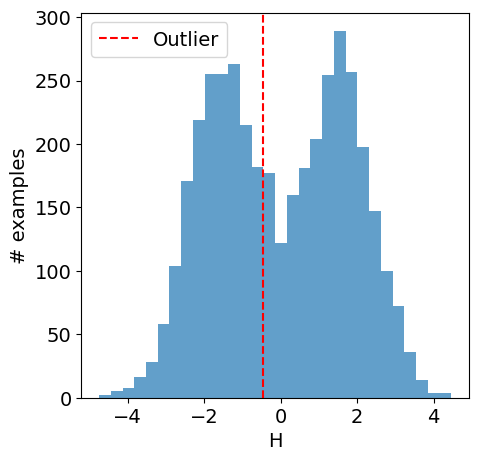

In [90]:
# Project X_n onto the first principal component 
H = np.dot(U[:,:k], Sigma[:k,:k]) # hidden/latent representation

plt.figure(figsize=(5,5))
plt.hist(H, bins=30, alpha=0.7)
plt.axvline(x=H[outlier_index], color='r', linestyle='--', label='Outlier') 
plt.xlabel('H')
plt.ylabel('# examples')
plt.legend()

# Outlier detection

Notice in the above that the outlier is not apparent in the first and second coordinates, 
nor in the first principal component. 

Then how can we detect it? 
The answer is to use "residuals" or "reconstruction errors". 

The residual of a data point is the difference between the original data point and its approximation. 

The residuals of the data points that are not outliers will be small, while the residual of the outlier will be large. 


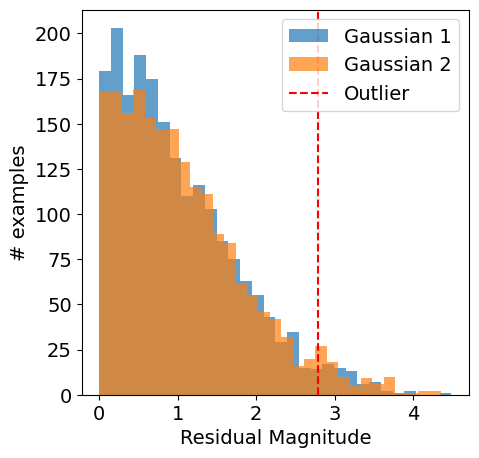

In [91]:
residuals = np.linalg.norm(X_n - X_n_hat, axis=1)
residuals1 = residuals[0:n1]
residuals2 = residuals[n1:]

# Plot residuals
plt.figure(figsize=(5,5))
plt.hist(residuals1, bins=30, alpha=0.7, label='Gaussian 1')
plt.hist(residuals2, bins=30, alpha=0.7, label='Gaussian 2')
plt.axvline(x=residuals[outlier_index], color='r', linestyle='--', label='Outlier')
plt.xlabel('Residual Magnitude')
plt.ylabel('# examples')
plt.legend()